In [53]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import optuna
import warnings

warnings.filterwarnings('ignore')

In [2]:
class Config:
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "song_popularity"
    CATEGORICAL_COLS = ["audio_mode", "time_signature", "key"]

DATA_PATH = "./data/"

In [3]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_test = pd.read_csv(DATA_PATH + "test.csv")

In [4]:
# split the training dataframe into kfolds for cross validation. We do this before any processing is done
# on the data. We use stratified kfold if the target distribution is unbalanced
def strat_kfold_dataframe(df, target_col_name, num_folds=5):
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # randomize of shuffle the rows of dataframe before splitting is done
    df = df.sample(frac=1, random_state=Config.RANDOM_SEED).reset_index(drop=True)
    # get the target data
    y = df[target_col_name].values
    skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X=df, y=y)):
        df.loc[val_index, "kfold"] = fold    
    return df     

df_train = strat_kfold_dataframe(df_train, target_col_name=Config.TARGET_COL_NAME, num_folds=Config.NUM_FOLDS)
df_train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,kfold
0,32823,144667.0,0.585599,0.691626,0.503891,0.222360,10.0,0.115524,-11.642316,0,0.049854,86.041825,3,0.539072,1,4
1,16298,203954.0,0.016664,0.667695,0.683820,0.001178,4.0,0.213299,NaN,1,0.102933,97.073546,3,0.667166,0,0
2,28505,179054.0,0.069471,0.624358,0.891436,0.000637,2.0,NaN,NaN,1,0.173795,140.102334,4,0.824423,0,1
3,6689,246074.0,0.333662,0.645299,0.716589,0.003159,2.0,0.114810,-9.178056,0,0.056690,101.694474,4,0.532739,1,3
4,26893,282403.0,0.378221,0.258557,0.617000,0.001366,7.0,0.172308,-6.721257,0,0.044904,123.402262,3,0.717549,0,1


In [5]:
cont_cols = ['song_duration_ms', 'acousticness', 'danceability', 'energy', 
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']

In [6]:
def impute_df_col(df, col_name, imputer):
    imputed_col = imputer.fit_transform(df[col_name].to_numpy().reshape(-1, 1))
    return pd.Series(imputed_col.reshape(-1))    

In [7]:
def impute_missing_values(df, cols, col_type="cont"):    
    if col_type == "cont":
        imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
    elif col_type == "cat":
        imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")            
    for col in cols:
        df[col] = impute_df_col(df, col, imputer)
    return df

In [8]:
#df_train = impute_missing_values(df_train, Config.CATEGORICAL_COLS, col_type="cat")
#df_train = impute_missing_values(df_train, cont_cols, col_type="cont")
#df_test = impute_missing_values(df_test, Config.CATEGORICAL_COLS, col_type="cat")
#df_test = impute_missing_values(df_test, cont_cols, col_type="cont")

In [9]:
train_cols_withnulls = [col for col in df_train.columns if df_train[col].isnull().any()]
test_cols_withnulls = [col for col in df_test.columns if df_test[col].isnull().any()]

In [10]:
def add_missing_col(df, cols_with_nulls):
    for col_name in cols_with_nulls:        
        df[col_name + "_missing"] = [int(item) for item in df[col_name].isna().values]
    return df        

df_train = add_missing_col(df_train, train_cols_withnulls)
df_test = add_missing_col(df_test, test_cols_withnulls)

In [11]:
df_train = pd.get_dummies(df_train, prefix=Config.CATEGORICAL_COLS, columns=Config.CATEGORICAL_COLS)
df_test = pd.get_dummies(df_test, prefix=Config.CATEGORICAL_COLS, columns=Config.CATEGORICAL_COLS)

In [12]:
cols_to_leave = ["id", "kfold", "song_popularity_proba", Config.TARGET_COL_NAME]
col_names = [item for item in df_train.columns.values.tolist() if item not in cols_to_leave]    

In [13]:
def get_input_features(df):
    cols_to_leave = ["id", "kfold", Config.TARGET_COL_NAME]
    col_names = [item for item in df.columns.values.tolist() if item not in cols_to_leave]        
    return df[col_names]

def get_fold_data(fold, df):
    df_train = df[df.kfold != fold]
    df_val = df[df.kfold == fold]    
    X_train = df_train[col_names]
    y_train = df_train[Config.TARGET_COL_NAME]
    X_val = df_val[col_names]
    y_val = df_val[Config.TARGET_COL_NAME]
    return X_train, y_train, X_val, y_val    

In [57]:
def run_training(train_X, train_y, val_X, val_y, params=None, callbacks=None):
    model = XGBClassifier(**params, verbosity=0)    
    #model = XGBRegressor(**params, verbosity=0)    
    if callbacks is not None:
        model.fit(
            train_X, 
            train_y,
            eval_metric="auc",
            eval_set=[(train_X, train_y), (val_X, val_y)],                        
            verbose=params["verbose"],
            callbacks=callbacks
        )    
    else:
        model.fit(
            train_X, 
            train_y,
            eval_metric="auc",
            eval_set=[(train_X, train_y), (val_X, val_y)],                        
            verbose=params["verbose"]
        )    
    y_val_pred = model.predict_proba(val_X)[:,1]
    auc = roc_auc_score(val_y, y_val_pred)
    return auc, model, y_val_pred    

In [61]:
def xgb_objective(trial):       
    params_dynamic = {   
        "subsample": trial.suggest_uniform("subsample", 0, 1),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0, 1),        
        "alpha": trial.suggest_uniform("alpha", 1e-2, 100),        
        "lambda": trial.suggest_uniform("lambda", 1e-2, 100),        
    }
    params_static = {        
        "objective":"binary:logistic",
        "n_jobs": 8,
        "seed": 42,
        'tree_method': "auto",        
        "eval_metric": "auc",
        "verbose": 0,
        "early_stopping_rounds": 200,
        "nrounds": 10000,
        "max_depth": 6,
        "max_leaves": 160        
    }    
    params = {**params_dynamic, **params_static}        
    # Add a callback for pruning.
    #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")    
    # fold_auc = []
    # for fold in range(Config.NUM_FOLDS):
    #     train_X, train_y, val_X, val_y = get_fold_data(fold, df_train)
    #     #auc_score, _, _ = run_training(train_X, train_y, val_X, val_y, params, callbacks=[pruning_callback])
    #     auc_score, _, _ = run_training(train_X, train_y, val_X, val_y, params)
    #     print(f"fold{fold} auc={auc_score}")
    #     fold_auc.append(auc_score)
    # mean_auc = np.mean(fold_auc)   
    # print(f"mean_auc = {mean_auc}")             
    # return mean_auc


    train_y = df_train[Config.TARGET_COL_NAME]
    train_data = xgb.DMatrix(data=df_train[col_names], label=train_y, feature_names=col_names)
    result = xgb.cv(
                params,
                dtrain = train_data,                
                nfold = Config.NUM_FOLDS,
                stratified = True,
                shuffle = True,
                seed = Config.RANDOM_SEED,                
                verbose_eval = 0,
                metrics=["auc"]
                #,callbacks=[pruning_callback]
            )
    #print(result)            
    mean_auc = np.mean(result["test-auc-mean"])
    return mean_auc

#study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize", study_name="LGBMModelTuning")    
study = optuna.create_study(direction="maximize", study_name="LGBMModelTuning")    
study.optimize(xgb_objective, n_trials=50)
print("Best trial:")
print(study.best_params)

[I 2022-01-31 12:12:35,503] A new study created in memory with name: LGBMModelTuning
[I 2022-01-31 12:12:37,027] Trial 0 finished with value: 0.54072286 and parameters: {'subsample': 0.7108879401423336, 'colsample_bytree': 0.8648380088311554, 'alpha': 81.31101609060669, 'lambda': 29.88044536003434}. Best is trial 0 with value: 0.54072286.
[I 2022-01-31 12:12:37,358] Trial 1 finished with value: 0.5023058 and parameters: {'subsample': 0.12605366988368416, 'colsample_bytree': 0.04951125674153789, 'alpha': 74.55784835976652, 'lambda': 76.0441560933783}. Best is trial 0 with value: 0.54072286.
[I 2022-01-31 12:12:37,930] Trial 2 finished with value: 0.5181560000000001 and parameters: {'subsample': 0.6217519475724821, 'colsample_bytree': 0.11434728134537286, 'alpha': 80.3850611440158, 'lambda': 49.96767234420163}. Best is trial 0 with value: 0.54072286.
[I 2022-01-31 12:12:38,895] Trial 3 finished with value: 0.54394776 and parameters: {'subsample': 0.3911790494029904, 'colsample_bytree': 0

Best trial:
{'subsample': 0.7317737344702202, 'colsample_bytree': 0.9276011442228465, 'alpha': 4.710603645575705, 'lambda': 20.53290326908413}


In [62]:
fold_metrics_model = []
fold_test_preds = []
model_params = {
        "n_estimators": 10000,
        "max_depth": 6,
        "max_leaves": 160,
        "objective":"binary:logistic",
        "n_jobs": 8,
        "seed": 42,
        'tree_method': "auto",        
        "eval_metric": "auc", 
        #"subsample": 0.7,
        "subsample": 0.73,
        #"colsample_bytree": 0.7,
        "colsample_bytree": 0.92,
        "alpha": 4.7,
        "lambda": 20,
        "learning_rate": 0.01,        
        "early_stopping_rounds": 500,
        "verbose": 0
    }    
for fold in range(Config.NUM_FOLDS):
    X_train, y_train, X_val, y_val = get_fold_data(fold, df_train)
    callbacks = [xgb.callback.EarlyStopping(rounds=model_params["early_stopping_rounds"], save_best=True)]    
    fold_auc_score, model, fold_val_pred = run_training(X_train, y_train, X_val, y_val, params=model_params, callbacks=callbacks)
    print(f"fold{fold} auc_score = {fold_auc_score}")
    fold_metrics_model.append((round(fold_auc_score, 4), model))


fold0 auc_score = 0.5690644092820856
fold1 auc_score = 0.5722741861763401
fold2 auc_score = 0.5822564938076711
fold3 auc_score = 0.5789253361803036
fold4 auc_score = 0.5760579918402593


In [63]:
fold_metrics = [item[0] for item in fold_metrics_model]
print(fold_metrics)    
mean_auc = np.mean(fold_metrics)
print(f"mean auc across folds = {mean_auc}")

[0.5691, 0.5723, 0.5823, 0.5789, 0.5761]
mean auc across folds = 0.5757399999999999


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

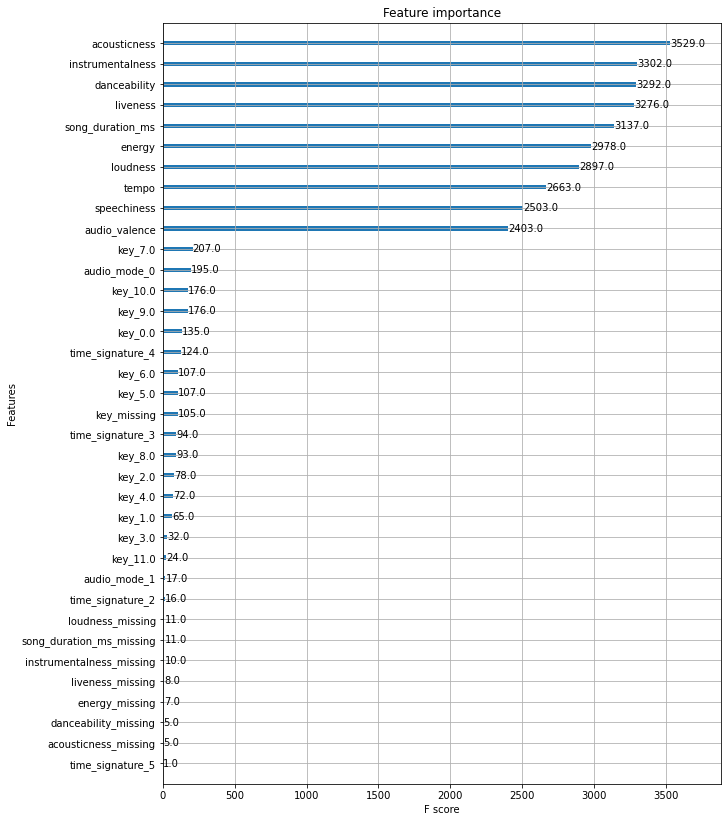

In [64]:
import xgboost
import matplotlib.pyplot as plt

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgboost.plot_importance(booster=booster, ax=ax)

fold_metrics_model_sorted = sorted(fold_metrics_model, key=lambda x:x[0], reverse=True) 
best_model = fold_metrics_model_sorted[0][1]
plot_features(best_model, (10, 14))

In [65]:
df_train["song_popularity_proba"] = 0.0
test_preds = {}
for fold in range(Config.NUM_FOLDS):
    model = fold_metrics_model[fold][1]
    train_df, train_y, val_df, val_y = get_fold_data(fold, df_train) 
    test_df = get_input_features(df_test)       
    # add the validation probability predictions for the fold to a new column in train data
    fold_val_preds = model.predict_proba(val_df)[:,1]
    fold_test_preds = model.predict_proba(test_df)[:,1]
    df_train.loc[df_train.kfold == fold, "song_popularity_proba"] = fold_val_preds
    pred_col_name = f"fold_{fold}_test_preds"
    test_preds[pred_col_name] = fold_test_preds 

In [66]:
df_test_preds = pd.DataFrame(test_preds)
test_pred_cols = [f"fold_{fold}_test_preds" for fold in range(Config.NUM_FOLDS)]
df_test_preds["mean_test_pred"] = df_test_preds[test_pred_cols].mean(axis=1)
print(f"Completed prediction for {len(df_test)} test rows")
df_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_submission['song_popularity']= df_test_preds["mean_test_pred"]
df_submission.to_csv('submission_xgb.csv',index=False)
df_submission.head()

Completed prediction for 10000 test rows


,id,song_popularity
0,0,0.440202
1,1,0.470073
2,2,0.261606
3,3,0.339572
4,4,0.351730


In [67]:
xgb_val_preds = df_train[["id", "song_popularity_proba", "song_popularity"]]
xgb_val_preds.to_csv("xgb_val_preds.csv")
print("Saved validation predictions for all folds to csv")

Saved validation predictions for all folds to csv


In [68]:
df_submission[df_submission.song_popularity > 0.5]

,id,song_popularity
168,168,0.509629
189,189,0.523912
249,249,0.516633
254,254,0.537297
326,326,0.514407
...,...,...
9760,9760,0.528037
9780,9780,0.526703
9821,9821,0.506579
9906,9906,0.520884
